# Plot Landsat Imagery Over Tuolumne

In [1]:
import ee
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
from rasterstats import zonal_stats
from rasterio.windows import from_bounds
import pickle
import json
from IPython.display import Image
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [18]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [20]:
mpl_epoch = '1970-01-01'
plt.rcParams['font.size'] = '13'

In [6]:
outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
#outline_gdf = outline_gdf.to_crs('epsg:32611')
cdec_geom = pickle.load(open('../../data/cdec/cdec_geometries.pkl', 'rb'))
#snotel_geom = snotel_geom.to_crs('epsg:32611')

atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))
snwd = pickle.load(open('../../data/cdec/cdec_gdf.pkl', 'rb'))

In [10]:
imgdir = '../../../data/landsat/tuolumne'

#2019
img_id1 = 'LC08_L1TP_042034_20190318_20200829_02_T1'
#2020
img_id2 = 'LC08_L1TP_042034_20200320_20200822_02_T1'
#2021
img_id3 = 'LC08_L1TP_042034_20210323_20210402_02_T1'
#2022
img_id4 = 'LC08_L1TP_042034_20220326_20220330_02_T1'

In [11]:
outline_gdf.bounds

,minx,miny,maxx,maxy
0,254150.467589,4.179331e+06,306650.467589,4.229641e+06


In [12]:
sample = os.path.join(imgdir, img_id1+'_B4.TIF')

with rio.open(sample) as src:
    r = src.read(1)
    r_shape = src.shape
    src_profile = src.profile
    src_bounds = src.bounds
    window = from_bounds((outline_gdf.bounds['minx'][0]-10000), (outline_gdf.bounds['miny'][0]-10000), (outline_gdf.bounds['maxx'][0]+10000), (outline_gdf.bounds['maxy'][0]+10000), src.transform)
    window_bounds = rio.windows.bounds(window, src.transform)
    window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]

In [13]:
def rio2ma(fn, b=1):
    #a = None
    with rio.open(fn) as src:
        a = src.read(b, window=window, masked=True)
    return a

In [14]:
def norm(array):
    percents=np.percentile(array, [2,98])
    normalized = (array - percents[0])/(percents[1]-percents[0])
    return np.clip(normalized,0,1)

In [15]:
from datetime import datetime

img_list = [img_id1,img_id2,img_id3,img_id4]
true_color_dict = {}
keys = ('2019', '2020', '2021', '2022')
dates = []
for img, key in zip(img_list, keys):
    #red
    r_fn = os.path.join(imgdir, img+'_B4.TIF')
    #Green
    g_fn = os.path.join(imgdir, img+'_B3.TIF')
    #Blue
    b_fn = os.path.join(imgdir, img+'_B2.TIF')
    
    r = rio2ma(r_fn, b=1)
    g = rio2ma(g_fn, b=1)
    b = rio2ma(b_fn, b=1)

    r_norm = norm(r)
    g_norm = norm(g)
    b_norm = norm(b)
    
    true_color_dict[key] = np.dstack((r_norm,g_norm,b_norm))
    date1=os.path.split(img)[1].split('_')[3]
    dates.append(datetime.strptime(date1, '%Y%m%d').date())

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [24]:
from matplotlib.lines import Line2D

boxplot_color = (31/255,119/255, 180/255, 0.5)

custom = [Line2D([], [], linestyle='-', color='darkorange'),
          Line2D([], [], linestyle='-', color='lightpink'),
          Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=boxplot_color, linestyle='None'),
          Line2D([], [], linestyle='-', color='k'),
          Line2D([], [], linestyle='--', color='lightgrey')]
    

custom_labels = ['Tuolumne Meadows', 'Dana Meadow', 'ATL06SR IQR', 'ATL06SR Median', 'Landsat Acquision Date']


In [89]:
type(atl06sr_gdf.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [90]:
atl06sr_gdf.index[0]

Timestamp('2018-11-09 22:09:43.662511060')

In [88]:
type(snwd_65.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [91]:
snwd_65.index[0]

Timestamp('2018-10-03 00:00:00')

In [87]:
type(cso_methow.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [92]:
cso_methow.index[0]

Timestamp('2020-02-02 22:08:04.920000+0000', tz='UTC')

In [29]:
snwd

,tum_m,dan_m,doy,decyear,dowy,dan_clean
Date,,,,,,
2018-10-01,0.0254,-0.0508,274.0,2018.747945,1.0,-0.0508
2018-10-02,0.0000,NaN,275.0,2018.750685,2.0,NaN
2018-10-03,0.0254,NaN,276.0,2018.753425,3.0,NaN
2018-10-04,0.0254,NaN,277.0,2018.756164,4.0,NaN
2018-10-05,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-06-30,0.0762,0.0000,181.0,2022.493151,273.0,0.0000
2022-07-01,0.0508,0.0000,182.0,2022.495890,274.0,0.0000
2022-07-02,0.0254,0.0000,183.0,2022.498630,275.0,0.0000


In [53]:
# Function adapted from David Shean by Hannah Besso
# REMOVE boxplot transparency (which indicated sample size)

def boxplot_date_landsat(df, col, groupby_col='acqdate', 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    
    # Calculate ATL06 stats in a format compatible with ax.bxp
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = (bp_alpha-bp_alpha.min())/(bp_alpha.max()-bp_alpha.min()) * (1 - 0.15) + 0.15
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # Set subplot layout
    mosaic= """
        AAAA
        AAAA
        BCDE
        """
    
    # Create figure
    fig = plt.figure(tight_layout=True, figsize=(10,8))
    ax_dict = fig.subplot_mosaic(mosaic)
    
    # Create Snotel color list
    #color_list = ['darkorange', 'lightpink', 'lightcoral', 'violet', 'indigo', 'mediumseagreen']
    
    # plot Snotel and CDEC data
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(ax=ax_dict['A'], alpha=1, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_clean'][snwd['dan_clean'] < 2.9].plot(ax=ax_dict['A'], alpha=1, color='lightpink', lw=2, label='Dana Meadows')
    
    
    # Plot ATL06 data
    bxp_f = ax_dict['A'].bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0}, boxprops= {'lw':0, 'alpha':0.2, 'edgecolor':'None'},  
                   widths=10, patch_artist=True)
    
    # Create my custom legend
    ax_dict['A'].legend(custom, custom_labels, loc='best', fontsize=10)
    
    # Set display keywords for the median lines on the boxplots
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(1)
        patch.set_color('black')  # or deeppink
        patch.set_linewidth(1.5)
    
    # Plot vertical lines for each landsat acquisition date
    for date1 in dates:
        ax_dict['A'].axvline(x=date1, ymin=clim[0], ymax=clim[1], c='lightgrey', linestyle='--')
    # Set various plotting parameters
    ax_dict['A'].axhline(0, color='k', lw=0.5)
    ax_dict['A'].set_ylabel('Snow Depth (m)')
    ax_dict['A'].set_ylim(*clim)
    ax_dict['A'].set_xlim([dt_min_plot, dt_max_plot])
    #ax_dict['A'].set_title(title) 
    ax_dict['A'].set_xlabel('')
    
    # # One attempt to remove the Jul xaxis label
    # x_axis = ax_dict['A'].axes.get_xaxis()
    # x_axis.set_label_text('foo')
    # x_label = x_axis.get_label()
    # x_label.set_visible(False)
    # # Another attempt to remove the Jul xaxis label
    # ax_dict['A'].axes.get_xaxis().set_ticks([])
    # ax_dict['A'].xaxis.set_ticklabels([])
    
     # Creating the custom xtick labels that I want
    years = mdates.YearLocator(month=10)
    ax_dict['A'].format_xdata = mdates.DateFormatter('%d-%m-%Y')
    years_fmt = mdates.DateFormatter('%d-%m-%Y')
    ax_dict['A'].xaxis.set_major_locator(years)
    ax_dict['A'].xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax_dict['A'].xaxis.set_minor_locator(months)
    ax_dict['A'].annotate(text='I) Snow Depth and Difference Values (ATL06SR - DTM)', xy=(0.02,0.95), xycoords='axes fraction', weight='bold')
    
    # Plot the Landsat imagery below the timeseries plot
    
    ax_dict['B'].imshow(true_color_dict['2019'], extent=window_extent)
    outline_gdf.plot(ax=ax_dict['B'], facecolor='none', edgecolor='magenta')
    cdec_geom[0:2].plot(ax=ax_dict['B'], color='magenta', marker='*', markersize=100)
    ax_dict['B'].set_title('A) 2019')
    #ax_dict['B'].annotate(text='B)', xy=(-0.12,0.9), xycoords='axes fraction')
    
    ax_dict['C'].imshow(true_color_dict['2020'], extent=window_extent)
    outline_gdf.plot(ax=ax_dict['C'], facecolor='none', edgecolor='magenta')
    cdec_geom[0:2].plot(ax=ax_dict['C'], color='magenta', marker='*', markersize=100)
    ax_dict['C'].set_title('B) 2020')
    #ax_dict['C'].annotate(text='C)', xy=(-0.12,0.9), xycoords='axes fraction')
    
    ax_dict['D'].imshow(true_color_dict['2021'], extent=window_extent)
    outline_gdf.plot(ax=ax_dict['D'], facecolor='none', edgecolor='magenta')
    cdec_geom[0:2].plot(ax=ax_dict['D'], color='magenta', marker='*', markersize=100)
    ax_dict['D'].set_title('C) 2021')
    #ax_dict['D'].annotate(text='D)', xy=(-0.12,0.9), xycoords='axes fraction')
    
    ax_dict['E'].imshow(true_color_dict['2022'], extent=window_extent)
    outline_gdf.plot(ax=ax_dict['E'], facecolor='none', edgecolor='magenta')
    cdec_geom[0:2].plot(ax=ax_dict['E'], color='magenta', marker='*', markersize=100)
    ax_dict['E'].set_title('D) 2022')
    ax_dict['B'].annotate(text='II Landsat', xy=(0,1.2), xycoords='axes fraction', weight='bold')
    
    # Set axis color of lansat plots to match the vertical dashed lines, and remove
    # axis ticks and labels. Also add a scalebar
    for ax in [ax_dict['B'], ax_dict['C'], ax_dict['D'], ax_dict['E']]:
        ax.spines['bottom'].set_color('lightgrey')
        ax.spines['top'].set_color('lightgrey')
        ax.spines['left'].set_color('lightgrey')
        ax.spines['right'].set_color('lightgrey')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
    ax_dict['B'].add_artist(ScaleBar(1, font_properties={'size':8}))
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

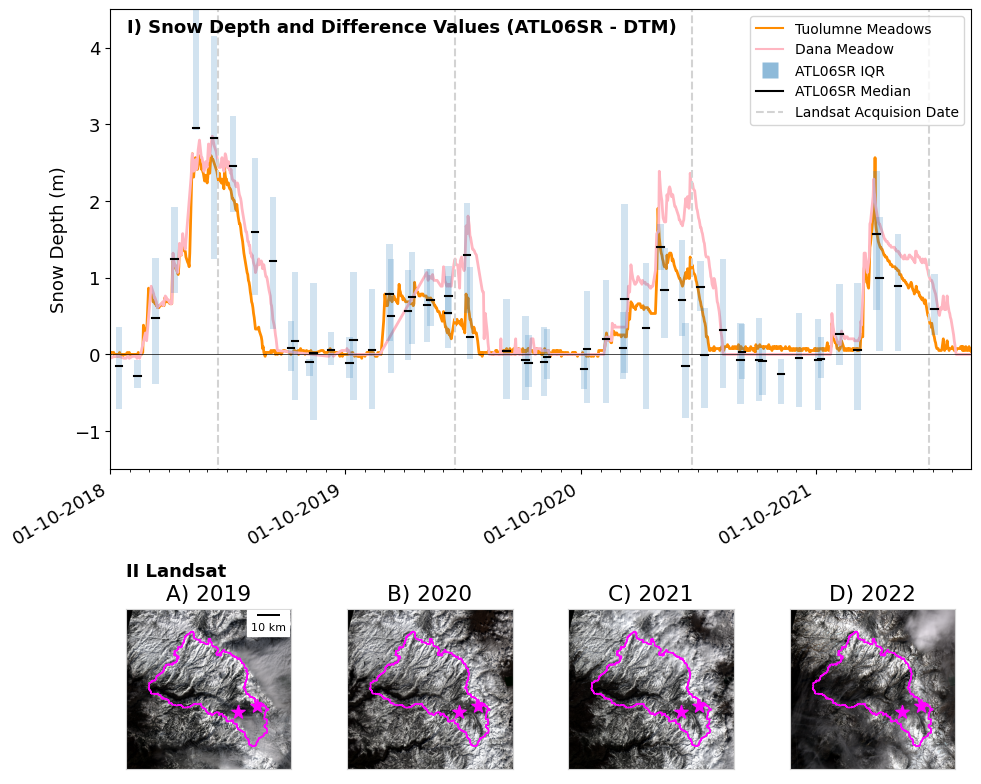

In [54]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_landsat(df=atl06sr_gdf, col='diff_plus', clim=(-1.5,4.5), name='boxplots_diffplus_landsat', title='All Diff Plus')

## GEE Didn't work for me...Here's what I was trying

In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1ARtbsJp2jGYSMWVeS4dtEtWXv9vx2SDUDKhlmjdTqKwqa3XyMJ1O54blPYo



Successfully saved authorization token.


In [4]:
# Import the Landsat collection.
lc = ee.ImageCollection('LANDSAT/LC08/C02/T1_RT')


In [12]:
#Feature to EE
def feature2ee(file):
    
    #Exception handler
    try:
        
        #check if the file is shapefile or CSV
        if file.endswith('.geojson'):
            gdf = gpd.read_file(file)
            g = [i for i in gdf.geometry]
            features=[]
            
            
            #for Polygon geo data type
            if (gdf.geom_type[0] == 'Polygon'):
                for i in range(len(g)):
                    g = [i for i in gdf.geometry]
                    x,y = g[i].exterior.coords.xy
                    cords = np.dstack((x,y)).tolist()

                    g=ee.Geometry.Polygon(cords)
                    feature = ee.Feature(g)
                    features.append(feature)
                print("done")

                ee_object = ee.FeatureCollection(features)
                
                return ee_object
            
                
            #for LineString geo data type   
            elif (gdf.geom_type[0] == 'LineString'):
                for i in range(len(g)):
                    g = [i for i in gdf.geometry]
                    x,y = g[i].exterior.coords.xy
                    cords = np.dstack((x,y)).tolist()
                    double_list = reduce(lambda x,y: x+y, cords)

                    g=ee.Geometry.LineString(double_list)
                    feature = ee.Feature(g)
                    features.append(feature)
                print("done")

                ee_object = ee.FeatureCollection(features)
                
                return ee_object
            
            
            #for Point geo data type
            elif (gdf.geom_type[0] == 'Point'):
                for i in range(len(g)):
                    g = [i for i in gdf.geometry]
                    x,y = g[i].exterior.coords.xy
                    cords = np.dstack((x,y)).tolist()
                    double_list = reduce(lambda x,y: x+y, cords)
                    single_list = reduce(lambda x,y: x+y, double_list)
                    
                    g=ee.Geometry.Point(single_list)
                    feature = ee.Feature(g)
                    features.append(feature)
                print("done")

                ee_object = ee.FeatureCollection(features)
                
                return ee_object
            
            
        #check if the file is shapefile or CSV
        #for CSV we need to have file with X and Y
        elif file.endswith('.csv'):
            df = pd.read_csv(file)
            features=[]
            for i in range(df.shape[0]):
                x,y = df.x[i],df.y[i]
                latlong =[x,y]
                g=ee.Geometry.Point(latlong) 
                feature = ee.Feature(g)
                features.append(feature)
            print("done")
                
            ee_object = ee.FeatureCollection(features)
            return ee_object
            
        
    except:
        
        print("Wrong file format")


In [13]:
#shapefile
fp =  "../../data/site_outlines/methow_outline_4326.geojson"

#call function
methow = feature2ee(fp)


done


In [18]:
# Initial date of interest (inclusive).
i_date = '2019-02-01'

# Final date of interest (exclusive).
f_date = '2019-03-15'

# Selection of appropriate bands and dates for LST.
lc = lc.select('B4', 'B3', 'B2').filterDate(i_date, f_date).filterBounds(methow)


In [26]:
lc

In [35]:
# code from https://stackoverflow.com/questions/46943061/how-to-iterate-over-and-download-each-image-in-an-image-collection-from-the-goog

In [27]:
collectionList = lc.toList(lc.size())

In [41]:
collectionList.get(0)

In [ ]:
collectionSize

In [31]:
image = ee.Image(collectionList.get(1)).clip(methow)

In [42]:
image

Type:           Image
String form:   
ee.Image({
           "functionInvocationValue": {
           "functionName": "Image.clip",
           "arguments": {
           <...>      }
           }
           }
           }
           }
           }
           }
           }
           }
           })
File:           ~/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/ee/image.py
Docstring:      An object to represent an Earth Engine image.
Init docstring:
Constructs an Earth Engine image.

Args:
  args: This constructor accepts a variety of arguments:
      - A string - an EarthEngine asset id,
      - A string and a number - an EarthEngine asset id and version,
      - A number - creates a constant image,
      - An ee.Array - creates a constant array image,
      - A list - creates an image out of each element of the array and
        combines them into a single image,
      - An ee.Image - returns the argument,
      - Nothing - results in an empty transparent image.
  versi

In [38]:
Image(url=image.getThumbURL({
    'min':0, 'max':255, 'dimensions':512, 'region':methow
}))

EEException: Request payload size exceeds the limit: 10485760 bytes.

In [37]:
url = image.getThumbUrl({})

EEException: Request payload size exceeds the limit: 10485760 bytes.

In [ ]:
for i in xrange(collectionSize):
    ee.batch.Export.image.toDrive(
        image = ee.Image(collectionList.get(i)).clip(rectangle), 
        fileNamePrefix = 'foo' + str(i + 1), 
        dimensions = '128x128').start()

In [ ]:
collectionList = sillyCollection.toList(sillyCollection.size())
collectionSize = collectionList.size().getInfo()
for i in xrange(collectionSize):
    ee.batch.Export.image.toDrive(
        image = ee.Image(collectionList.get(i)).clip(rectangle), 
        fileNamePrefix = 'foo' + str(i + 1), 
        dimensions = '128x128').start()


# Using David's Code from Lab 5

In [43]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np

In [44]:
from osgeo import gdal
import rasterio as rio
import rasterio.plot

In [45]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [46]:
#We want to use interactive plotting for zoom/pan and live coordinate display
%matplotlib widget
#%matplotlib inline

In [47]:
#Create local directory to store images
imgdir = '../data/LS8_sample'
if not os.path.exists(imgdir):
    os.makedirs(imgdir)

In [48]:
#Use Google Cloud archive
base_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01'

#Define Landsat path/row for Western Washington
path = 46
path2 = 45
row = 26

#Pre-identified cloud-free Image IDs for this path/row 
#Summer 2018
#img_id1 = 'LC08_L1TP_046026_20190226_20200829_02_T1'
#Winter 2018
img_id1 = 'LC08_L1TP_045026_20190307_20200829_02_T1'

img_id2 = 'LC08_L1TP_046026_20190210_20200829_02_T1'

img_list = (img_id2, img_id1)
#img_list = (img_id1,)

In [49]:
#Loop through all selected images and all bands
for img in img_list:
    for b in range(1,12):
        #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1:03d}/{2:03d}/{3}/{3}_B{4}.TIF'.format(base_url, path, row, img, b)
        print(image_url)
        #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
        #Check to see if file already exists
        if not os.path.exists(out_fn):
            print("Saving:", out_fn)
            #Download the file
            urllib.request.urlretrieve(image_url, out_fn)

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/046/026/LC08_L1TP_046026_20190210_20200829_02_T1/LC08_L1TP_046026_20190210_20200829_02_T1_B1.TIF
Saving: ../data/LS8_sample/LC08_L1TP_046026_20190210_20200829_02_T1_B1.TIF


HTTPError: HTTP Error 404: Not Found